<a href="https://colab.research.google.com/github/calibretaliation/DeepLearning20211/blob/main/DenseNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! git clone https://github.com/calibretaliation/DeepLearning20211

Cloning into 'DeepLearning20211'...
remote: Enumerating objects: 32610, done.
remote: Counting objects: 100% (144/144), done.
remote: Compressing objects: 100% (144/144), done.
remote: Total 32610 (delta 83), reused 0 (delta 0), pack-reused 32466
Receiving objects: 100% (32610/32610), 1.68 GiB | 35.69 MiB/s, done.
Resolving deltas: 100% (141/141), done.
Checking out files: 100% (32428/32428), done.


In [2]:
! pip install albumentations==0.4.6
! pip install sklearn

     |████████████████████████████████| 117 kB 15.9 MB/s 
     |████████████████████████████████| 948 kB 46.0 MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-py3-none-any.whl size=65172 sha256=dbbd5ce62aa4e66178c797d65915df1c430c1acde7706ced9e15063f14ff95ef
  Stored in directory: /root/.cache/pip/wheels/cf/34/0f/cb2a5f93561a181a4bcc84847ad6aaceea8b5a3127469616cc
Successfully built albumentations
  Attempting uninstall: imgaug
    Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [3]:
! nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0


In [4]:
import random
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import math

import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.io import read_image
import torchvision.models as models
import torch.nn as nn
from torch.autograd import Variable
from torchsummary import summary
import torch.nn.functional as F

import albumentations as A
import albumentations.pytorch
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import StratifiedKFold, GroupKFold
from sklearn.preprocessing import LabelEncoder


In [5]:
train_df = pd.read_csv('./DeepLearning20211/data/train.csv')
test_df = pd.read_csv('./DeepLearning20211/data/test.csv')
train_img_path = './DeepLearning20211/data/train_images'
test_img_path = './DeepLearning20211/data/test_images'

In [6]:
def my_seed(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
my_seed(33)

In [7]:
train_df['file_path'] = train_df.image.apply(lambda x: os.path.join(train_img_path, x))
train_df.head(5)

,posting_id,image,image_phash,title,label_group,file_path
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794,./DeepLearning20211/data/train_images/0000a688...
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045,./DeepLearning20211/data/train_images/00039780...
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891,./DeepLearning20211/data/train_images/000a190f...
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,4093212188,./DeepLearning20211/data/train_images/00117e4f...
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,3648931069,./DeepLearning20211/data/train_images/00136d1c...


In [8]:
# Drop duplicate by p-hash
# train_df = train_df.drop_duplicates(subset=['image_phash'],keep = 'first')
train_df = train_df.reset_index()
train_df.image_phash.value_counts()

fad28daa2ad05595    26
d0c0ea37bd9acce0    20
be12e12f9ec1e198    17
e992966d4ba49761    16
f6d98134b904b56b    16
                    ..
e636c9c9993c3266     1
ee6a979591b4d019     1
e88f977092316d8e     1
e699cc6693a593a4     1
b7c1e87e87d0805e     1
Name: image_phash, Length: 28735, dtype: int64

In [9]:
#check if label group preserved
train_df.label_group.value_counts()

994676122     51
159351600     51
562358068     51
3113678103    51
1163569239    51
              ..
3996065489     2
517023446      2
2101581536     2
3460538113     2
3927456083     2
Name: label_group, Length: 11014, dtype: int64

In [10]:
group_k_fold = GroupKFold(n_splits= 5)
train_df['fold'] = -1
for fold, (train_idx, valid_idx) in enumerate(group_k_fold.split(train_df, None, train_df.label_group)):
    train_df.loc[valid_idx, 'fold'] = fold
train_df['fold'].value_counts()

0    6851
4    6850
3    6850
2    6850
1    6849
Name: fold, dtype: int64

In [11]:
le = LabelEncoder()
train_df.label_group = le.fit_transform(train_df.label_group)
train_df['label_group'].value_counts()

2606     51
8037     51
1445     51
412      51
2994     51
         ..
10795     2
4652      2
6701      2
558       2
8172      2
Name: label_group, Length: 11014, dtype: int64

In [12]:
class ShopeeDataset(Dataset):

    def __init__(self, dataframe, dir_path, mode, transforms):
        self.dataframe = dataframe
        self.dir_path = dir_path
        self.augmentations = transforms
        self.mode = mode
    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        img_info = self.dataframe.iloc[index]
        img = cv2.imread(img_info.file_path)
        label = torch.tensor([img_info['label_group']])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        if self.augmentations:
            augmented = self.augmentations(image=img)
            img = augmented['image']   

        if self.mode == 'test':
            return torch.tensor(img).float()
        else:
            return torch.tensor(img).float(), torch.tensor(img_info.label_group).int()
      

transforms_train = albumentations.Compose([ 
    albumentations.augmentations.transforms.Flip(),
    albumentations.augmentations.transforms.Cutout(),
    albumentations.augmentations.transforms.ShiftScaleRotate(rotate_limit=180, p=0.5, interpolation = cv2.INTER_LANCZOS4),
    albumentations.augmentations.transforms.Normalize(mean=(0, 0, 0), std=(1, 1, 1)),
    albumentations.augmentations.transforms.Resize(64, 64), 
    ToTensorV2() 
    ])
transforms_valid = albumentations.Compose([
    albumentations.Normalize(mean=(0, 0, 0), std=(1, 1, 1)),
    albumentations.Resize(64, 64),
    ToTensorV2()
])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


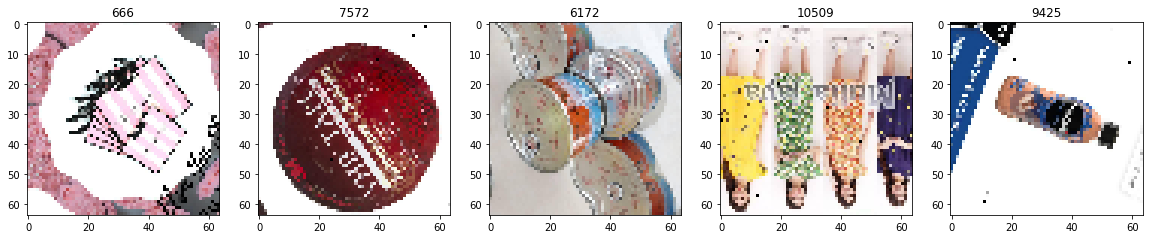

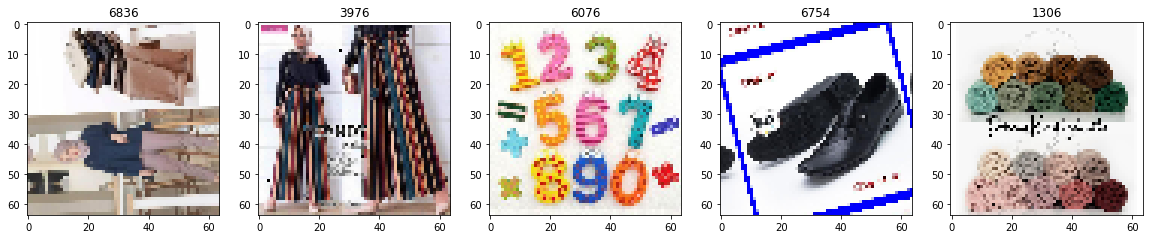

In [13]:
fold_id = 0
train_fold_id = train_df[train_df['fold'] != fold_id]
valid_fold_id = train_df[train_df['fold'] == fold_id]

train_ds = ShopeeDataset(train_fold_id, train_img_path, 'train' , transforms_train)
valid_ds = ShopeeDataset(valid_fold_id, train_img_path, 'valid' , transforms_valid)

my_seed(33)
train_loader = DataLoader(train_ds, batch_size = 4, shuffle = True)
valid_loader = DataLoader(valid_ds, batch_size = 4, shuffle = True)

for i in range(2):
    f, axarr = plt.subplots(1,5, figsize = (20,4))
    for p in range(5):
        idx = i*5 + p
        img, label = train_ds[idx]
        axarr[p].imshow(img.transpose(0,1).transpose(1,2).squeeze())
        axarr[p].set_title(label.item())

In [14]:
class BottleNeck(nn.Module):
    def __init__(self, input_size, growthRate):
        super(BottleNeck,self).__init__()
        outChannels = 4*growthRate
        self.bn1 = nn.BatchNorm2d(input_size)
        self.conv1 = nn.Conv2d(input_size, outChannels, kernel_size = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(outChannels)
        self.conv2 = nn.Conv2d(outChannels, growthRate, kernel_size = 3, bias = False, padding = 1)
    def forward(self, x):
        out = self.bn1(x)
        #print("Batch normalize 1", out.shape)
        out = self.conv1(F.relu(out))
        #print("conv 1", out.shape)        
        out = self.bn2(out)
        #print("Batch normalize 2", out.shape)
        out = self.conv2(F.relu(out))
        #print("conv 2", out.shape)  
        out = torch.cat((out,x),1)
        #print("cat", out.shape)  
        return out

class SingleLayer(nn.Module):
    def __init__(self, input_size, growthRate):
        super(SingleLayer, self).__init__()
        self.bn1 = nn.BatchNorm2d(input_size)
        self.conv1 = nn.Conv2d(input_size, growthRate, kernel_size=3,
                               padding=1, bias=False)

    def forward(self, x):
        out = self.bn1(x)
        out = self.conv1(F.relu(out))
        #out = torch.cat((x, out), 1)
        return out

class TransitionLayer(nn.Module):
    def __init__(self, input_size, output_size):
        super(TransitionLayer, self).__init__()
        self.bn1 = nn.BatchNorm2d(input_size)
        self.conv1 = nn.Conv2d(input_size, output_size, kernel_size = 1, bias = False)
    def forward(self, x):
        out = self.bn1(x)
        out = self.conv1(F.relu(out))
        out = F.avg_pool2d(out, 2)
        return out

class DenseNetShopee(nn.Module):
    def __init__(self, growthRate, num_denseBlocks, reduction, num_classes, bottleneck):
        super(DenseNetShopee, self).__init__()
        num_channels = 2*growthRate
        self.conv1 = nn.Conv2d(3, num_channels, kernel_size=3, padding=1, bias=False)
        self.pooling1 = nn.AvgPool2d(kernel_size = 3, stride = 2)


        self.dense1 = self._make_dense(num_channels, growthRate, num_denseBlocks, bottleneck)
        num_channels += num_denseBlocks*growthRate
        nOutChannels = int(math.floor(num_channels*reduction))
        self.trans1 = TransitionLayer(num_channels, nOutChannels)

        num_channels = nOutChannels
        self.dense2 = self._make_dense(num_channels, growthRate, num_denseBlocks, bottleneck)
        num_channels += num_denseBlocks*growthRate
        nOutChannels = int(math.floor(num_channels*reduction))
        self.trans2 = TransitionLayer(num_channels, nOutChannels)

        num_channels = nOutChannels
        #self.dense3 = self._make_dense(num_channels, growthRate, num_denseBlocks, bottleneck)
        #num_channels += num_denseBlocks*growthRate
        #nOutChannels = int(math.floor(num_channels*reduction))

        self.single = SingleLayer(num_channels, growthRate)
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.flatten = nn.Flatten(1)
        self.fc = nn.Linear(8192, num_classes)
        self.activate = nn.LeakyReLU(0.1)
    def forward(self, x):
        #print('x', x.shape)
        x = self.conv1(x)
        #print('Conv1', x.shape)
        x = self.dense1(x)
        #print('Dense 1',x.shape)
        x = self.trans1(x)
        #print('Trans 1', x.shape)
        x = self.dense2(x)
        #print('Dense 2', x.shape)
        x = self.trans2(x)
        #print('Trans 2', x.shape)
        #x = self.dense3(x)
        #print('Dense 3', x.shape)
        #x = torch.squeeze(x, dim = 183)
        x = self.single(x)
        #print('Single ', x.shape)
        x = self.flatten(x)
        #print(x.shape)
        x = self.fc(x)
        x = self.activate(x)
        x = nn.Dropout(p = 0.2)(x)

        return x

    def _make_dense(self, num_channels, growthRate, num_denseBlock, bottleneck):
        layer = []
        for i in range(num_denseBlock):
            if bottleneck:
                layer.append(BottleNeck(num_channels, growthRate))
            else: 
                layer.append(SingleLayer(num_channels, growthRate))
            num_channels += growthRate
        return nn.Sequential(*layer)

In [15]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')
num_classes = 11014
learning_rate = 0.1
batch_size = 64
display_step = 16
epochs = 5
checkpoint = 'Densenet.pth'

Using cpu device


In [16]:
bottle_neck = BottleNeck(32, 32)
model = DenseNetShopee(32, 4, 0.3, num_classes, bottle_neck).to(device)
summary(model, (3,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,728
       BatchNorm2d-2           [-1, 64, 64, 64]             128
            Conv2d-3          [-1, 128, 64, 64]           8,192
       BatchNorm2d-4          [-1, 128, 64, 64]             256
            Conv2d-5           [-1, 32, 64, 64]          36,864
        BottleNeck-6           [-1, 96, 64, 64]               0
       BatchNorm2d-7           [-1, 96, 64, 64]             192
            Conv2d-8          [-1, 128, 64, 64]          12,288
       BatchNorm2d-9          [-1, 128, 64, 64]             256
           Conv2d-10           [-1, 32, 64, 64]          36,864
       BottleNeck-11          [-1, 128, 64, 64]               0
      BatchNorm2d-12          [-1, 128, 64, 64]             256
           Conv2d-13          [-1, 128, 64, 64]          16,384
      BatchNorm2d-14          [-1, 128,

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
best_val_loss = 999

In [19]:
def train_loop(epoch, model, train_data_loader):
    model.train()
    for batch_idx, (data, target) in enumerate(train_data_loader):
        data, target = data.to(device), target.to(device).to(torch.int64)
        optimizer.zero_grad() 
        output = model(data)
        loss = criterion(output, target)
        loss.backward() 
        optimizer.step()
        optimizer.zero_grad() 
        if batch_idx % display_step == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test_loop(model, test_data_loader):
    global best_val_loss
    model.eval()
    test_loss = 0
    correct = 0
    # set no grad cho quá trình testing
    with torch.no_grad():
        for data, target in test_data_loader:
            data, target = data.to(device), target.to(device).to(torch.int64)
            output = model(data)
            output = F.log_softmax(output,dim=1) # log softmax dùng F, chú ý dim
            test_loss += criterion(output, target)
            pred = output.argmax(dim =1, keepdim = True) # argmax để lấy predicted label, chú ý dim, và keepdim = True
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_data_loader.dataset) 
    if test_loss < best_val_loss:
        best_val_loss = test_loss
        torch.save(model.state_dict(),checkpoint) # lưu lại model 
        print("***********   SAVEEEEEEE TEST_ACC = {}%    ***********".format(correct))         
    print("***********    TEST_ACC = {}%    ***********".format(correct))

In [ ]:
for fold_id in range(5):
    #if fold_id > 1:
        #model.load_state_dict(torch.load(checkpoint))
    train_fold_id = train_df[train_df['fold'] != fold_id]
    valid_fold_id = train_df[train_df['fold'] == fold_id]

    train_ds = ShopeeDataset(train_fold_id, train_img_path, 'train' , transforms_train)
    valid_ds = ShopeeDataset(valid_fold_id, train_img_path, 'valid' , transforms_valid)

    train_loader = DataLoader(train_ds, batch_size = batch_size, shuffle = True)
    valid_loader = DataLoader(valid_ds, batch_size = batch_size, shuffle = True)
    for epoch in range(epochs):
      train_loop(epoch, model, train_loader)
      test_loop(model, valid_loader)
    print('FOLD {} COMPLETE ! '.format(fold_id+1))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train Epoch: 0 [0/27399 (0%)]	Train Loss: 9.300547
Train Epoch: 0 [1024/27399 (4%)]	Train Loss: 32.798012
Train Epoch: 0 [2048/27399 (7%)]	Train Loss: 9.307906
Train Epoch: 0 [3072/27399 (11%)]	Train Loss: 9.287842
Train Epoch: 0 [4096/27399 (15%)]	Train Loss: 9.252829
Train Epoch: 0 [5120/27399 (19%)]	Train Loss: 9.222914
Train Epoch: 0 [6144/27399 (22%)]	Train Loss: 9.265318
Train Epoch: 0 [7168/27399 (26%)]	Train Loss: 9.306408
Train Epoch: 0 [8192/27399 (30%)]	Train Loss: 9.336116
Train Epoch: 0 [9216/27399 (34%)]	Train Loss: 9.249165
Train Epoch: 0 [10240/27399 (37%)]	Train Loss: 9.293027
Train Epoch: 0 [11264/27399 (41%)]	Train Loss: 9.247353
Train Epoch: 0 [12288/27399 (45%)]	Train Loss: 9.328112
Train Epoch: 0 [13312/27399 (48%)]	Train Loss: 9.270328
Train Epoch: 0 [14336/27399 (52%)]	Train Loss: 9.373574
Train Epoch: 0 [15360/27399 (56%)]	Train Loss: 9.350791
Train Epoch: 0 [16384/27399 (60%)]	Train Loss: 9.318140
Train Epoch: 0 [17408/27399 (63%)]	Train Loss: 9.255398
Train E